# Customer Segmentation for E-commerce Personalization

**Goal:** Cluster customers into meaningful segments using purchasing behavior from the Kaggle e-commerce events dataset.

**Dataset URL:** `https://data.rees46.com/datasets/marketplace/2019-Oct.csv.gz`

Note: The dataset is large (5GB+), so we will use a smaller sample for this example. If you want to use the dataset, please download it from the above URL and place it in the `data` folder. The file name should be `2019-Oct.csv` because I am not pushing the dataset to the repository due to its size.


In [1]:
# Uncomment the following line to install required packages if not already installed
#!pip install -r requirements.txt

In [2]:
from src.helpers.cluster_analyzer import ClusterAnalyzer
# import necessary libraries

from src.helpers.data_loading_helper import DataLoader
import tabulate as tb
import matplotlib.pyplot as plt
import seaborn as sns
from src.helpers.cluster_helper import KMeansClustering


## 1. Data Loading and Exploration

I have created a `DataLoader` class to handle the loading and basic exploration of the dataset. This class will help us load the data, view its structure, and perform initial analysis.

In [3]:
data_loader = DataLoader(file_path='../data/2019-Oct.csv')
df = data_loader.load_data()

print(tb.tabulate(df.head(),headers='keys',tablefmt='psql'))

+----+-------------------------+--------------+--------------+---------------------+-------------------------------------+----------+---------+-----------+--------------------------------------+
|    | event_time              | event_type   |   product_id |         category_id | category_code                       | brand    |   price |   user_id | user_session                         |
|----+-------------------------+--------------+--------------+---------------------+-------------------------------------+----------+---------+-----------+--------------------------------------|
|  0 | 2019-10-01 00:00:00 UTC | view         |     44600062 | 2103807459595387724 | nan                                 | shiseido |   35.79 | 541312140 | 72d76fde-8bb3-4e00-8c23-a032dfed738c |
|  1 | 2019-10-01 00:00:00 UTC | view         |      3900821 | 2053013552326770905 | appliances.environment.water_heater | aqua     |   33.2  | 554748717 | 9333dfbd-b87a-4708-9857-6336556b0fcc |
|  2 | 2019-10-01 00:00:0

The original dataset is more than 5GB and have more than 104000 rows. For the sake of this example, we will use a smaller sample of the data to demonstrate the customer segmentation process. I have set the row limit to 10000 rows.

##### **Dataset features:**

- `event_time`: Timestamp of the event
- `event_type`: Type of event (e.g., view, add to cart, purchase)
- `product_id`: Unique identifier for the product
- `category_id`: Unique identifier for the product category
- `category_code`: Hierarchical category code for the product
- `brand`: Brand of the product
- `price`: Price of the product
- `user_id`: Unique identifier for the user
- `user_session`: Unique identifier for the user session

##### Event Types:
- `view`: User viewed the product
- `add_to_cart`: User added the product to the cart
- `purchase`: User purchased the product

The distribution of these events are given in the below plot.

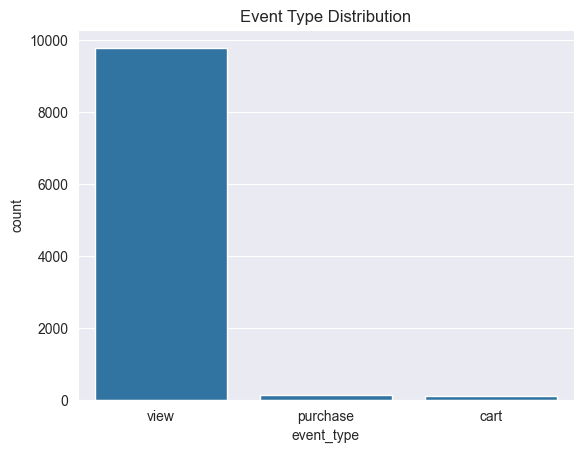

In [4]:
data_loader.plot_event_distribution()

##### Dataset Insights:

To get insights into the dataset, we will perform some basic analysis to understand the distribution of events, products, and users.

In [5]:
# This will give us the features and their data types
data_loader.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   event_time     10000 non-null  object 
 1   event_type     10000 non-null  object 
 2   product_id     10000 non-null  int64  
 3   category_id    10000 non-null  int64  
 4   category_code  6723 non-null   object 
 5   brand          8558 non-null   object 
 6   price          10000 non-null  float64
 7   user_id        10000 non-null  int64  
 8   user_session   10000 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 703.3+ KB


In [6]:
# To get the numeric summary of the dataset, we can use the describe method
data_loader.df.describe()

,product_id,category_id,price,user_id
count,1.000000e+04,1.000000e+04,10000.000000,1.000000e+04
mean,1.024055e+07,2.055768e+18,294.079982,5.314151e+08
std,1.102505e+07,1.391996e+16,365.510001,1.691443e+07
min,1.002099e+06,2.053014e+18,0.000000,3.064418e+08
25%,1.005105e+06,2.053014e+18,62.940000,5.154591e+08
50%,5.100564e+06,2.053014e+18,159.330000,5.280995e+08
75%,1.620033e+07,2.053014e+18,362.940000,5.480955e+08
max,5.300000e+07,2.172371e+18,2574.070000,5.554648e+08


We can also get more by plotting the distribution of the numeric features in the dataset. I have plotted the the top 10 most viewed, added to cart and purchased products.

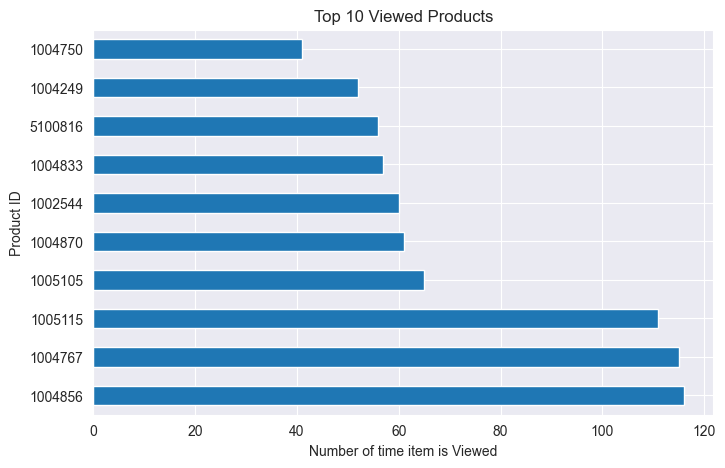

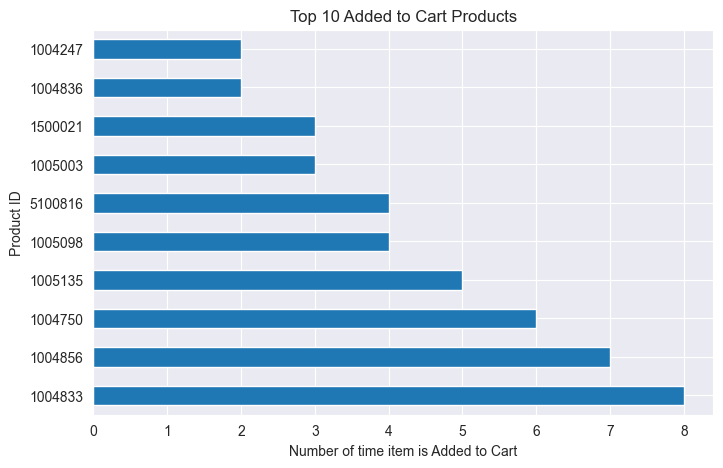

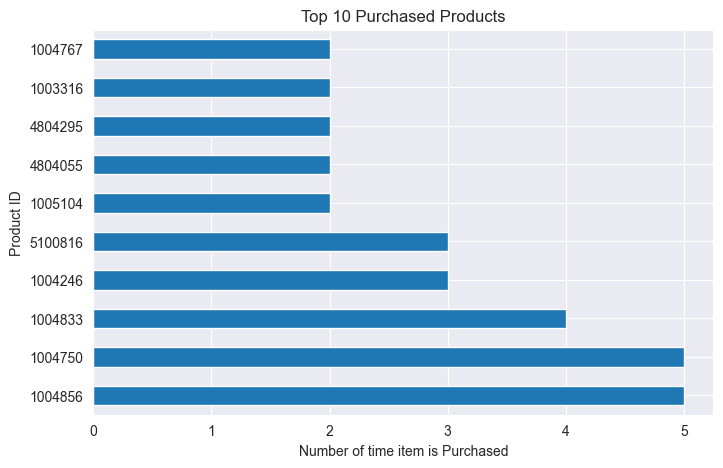

In [7]:
# Most viewed products
data_loader.plot_products_with_type(type_name='view', x_label='Viewed')
data_loader.plot_products_with_type(type_name='cart', x_label='Added to Cart')
data_loader.plot_products_with_type(type_name='purchase', x_label='Purchased')




## 2.	Data Preprocessing and Feature Engineering

##### Handling missing values and duplicates
In this step we will check whether dataset have any missing or duplicate values. If yes we will delete the duplicate records and fill the missing values by taking the mean of the respective column. If they are categorical values, we will just drop them.

In [8]:
missing_values  = data_loader.check_missing_values()
print(tb.tabulate(missing_values, headers='keys', tablefmt='psql'))

+----+---------------+------------------+
|    | Column        |   Missing Values |
|----+---------------+------------------|
|  0 | event_time    |                0 |
|  1 | event_type    |                0 |
|  2 | product_id    |                0 |
|  3 | category_id   |                0 |
|  4 | category_code |             3277 |
|  5 | brand         |             1442 |
|  6 | price         |                0 |
|  7 | user_id       |                0 |
|  8 | user_session  |                0 |
+----+---------------+------------------+


Now we can see that there are missing values in category_code and category_id. Since these are categorical values we cannot fill them with mean. So we fill drop these rows from the dataset.

In [9]:
data_loader.drop_missing_values()

Dropped 3828 rows containing missing values.
New dataset shape: (6172, 9)


In [10]:
# Now we can check for duplicate values in the dataset. If there are any, we will drop them.
dropped_rows  = data_loader.check_duplicates()
print(f'{dropped_rows} duplicated rows were dropped from the dataset.')

Number of duplicate rows: 3
3 duplicated rows were dropped from the dataset.


**What features could be relevant for customer segmentation? How would you preprocess them?**

To identify relevant features for customer segmentation, we can consider the following:

##### User Behavior Features:
* Number of views, adds to cart, and purchases per user.
* Average purchase value and total spending.
* Purchase frequency and recency of last purchase.
##### Product Interaction Features:
* Most purchased or viewed product categories.
* Diversity of products purchased (variety score).
##### Time-based Features:
* Preferred shopping days and hours.
* Seasonal or monthly purchase patterns.

Preprocessing Steps:
##### Feature Engineering:
* Aggregate user activity to compute total views, carts, and purchases per user.
* Calculate derived metrics like purchase frequency, recency, and average order value.
* Encode categorical variables such as product categories using one-hot encoding.
##### Normalization/Scaling:
Apply MinMaxScaler or StandardScaler to numerical features so that all values are on a comparable scale.
##### Outlier Handling:
Detect and remove or cap extreme values in spending or activity counts to prevent skewing clustering results.
##### Dimensionality Reduction (we can do this only if needed):
We can use PCA to reduce feature space while preserving variance, improving clustering efficiency.


## 3. Exploratory Data Analysis (EDA):

I have already plotted the event type distribution and products graphs. Other than basic EDA in the previous steps. Now we will focus on visualizing the data to understand the distribution of features and relationships between them.


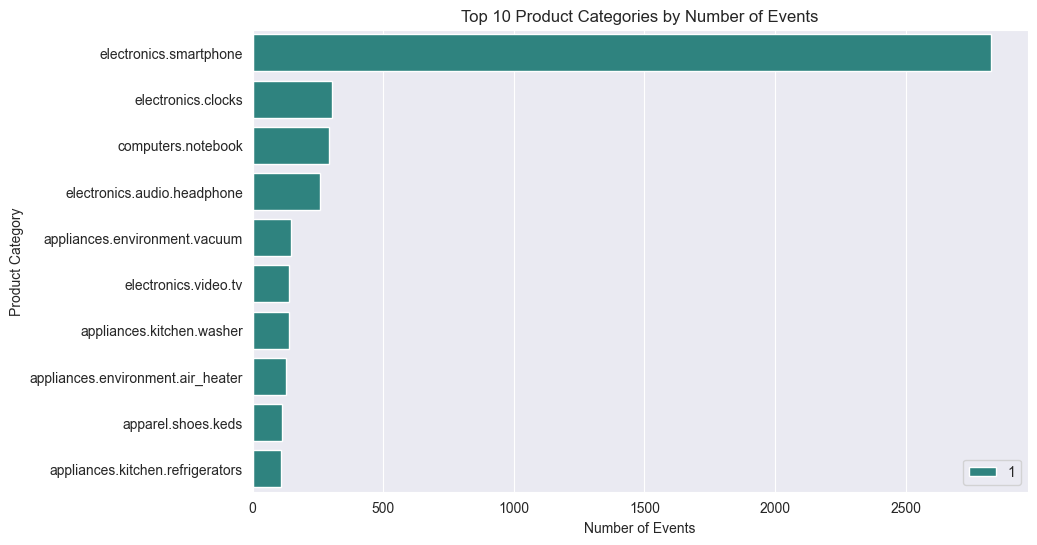

In [11]:
# Count number of events per product category
category_counts = data_loader.df['category_code'].value_counts().head(10)  # top 10 categories

# Plot a horizontal bar chart
plt.figure(figsize=(10,6))
sns.barplot(x=category_counts.values, y=category_counts.index, palette="viridis",hue=1)
plt.title("Top 10 Product Categories by Number of Events")
plt.xlabel("Number of Events")
plt.ylabel("Product Category")
plt.show()

To understand which data can be helpful for customer segmentation, we can visualize the relationship between user activity and product categories. For example, we can plot the number of events per user and the most popular product categories.

C:\Users\chris\AppData\Local\Temp\ipykernel_28352\3351624235.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


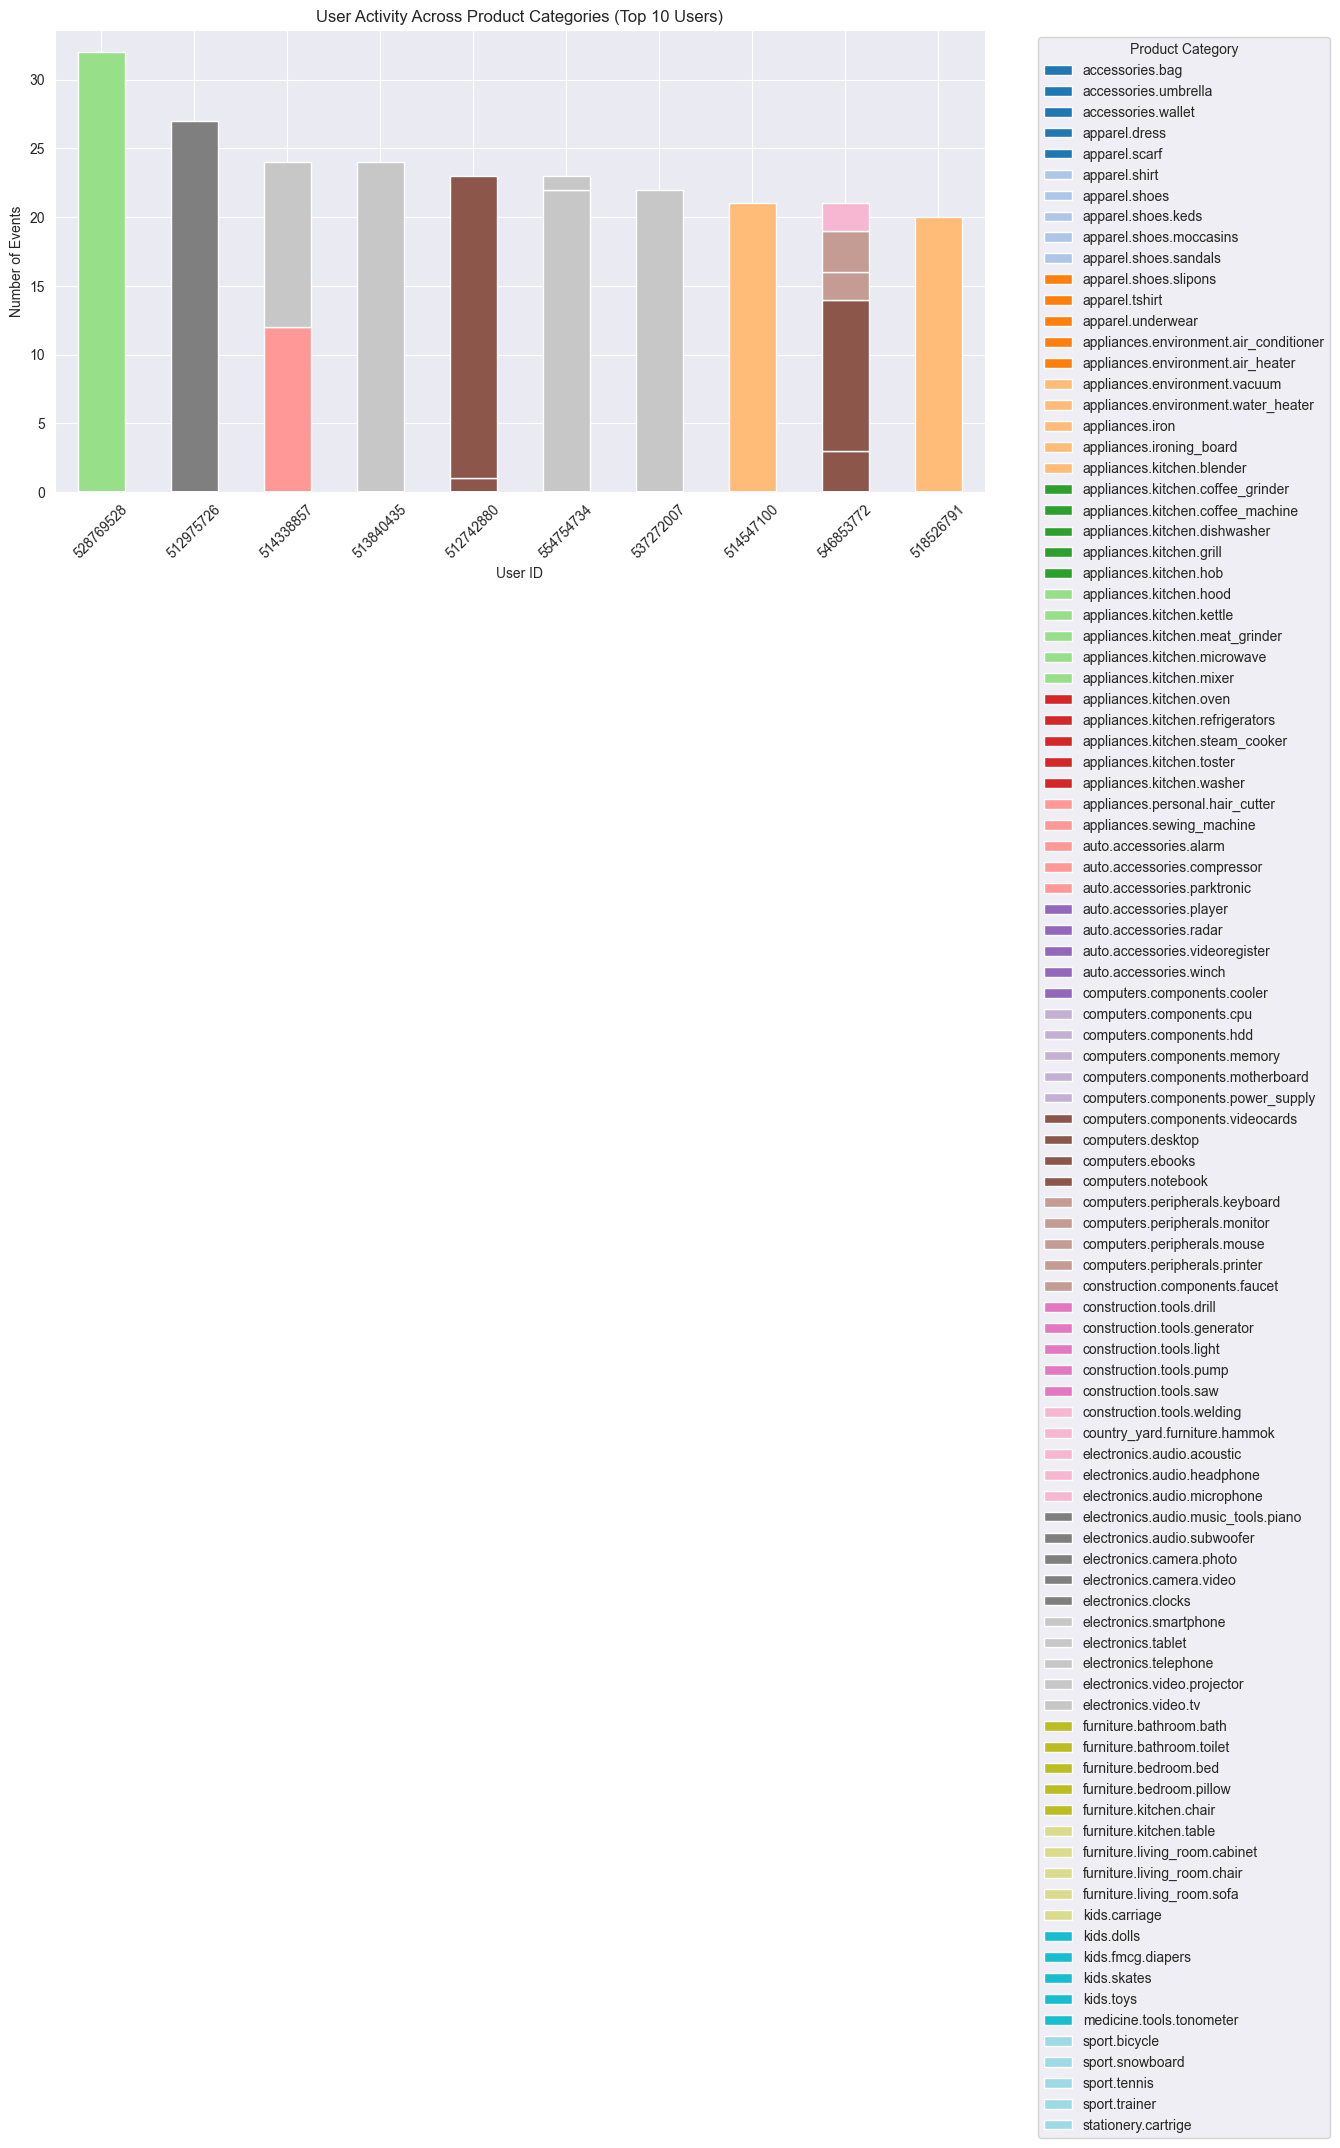

In [12]:
# Step 1: Aggregate data - count of events per user per category
user_category_counts = data_loader.df.groupby(['user_id', 'category_code'])['event_type'].count().unstack(fill_value=0)

# Step 2: Select top 10 users by total events for clarity
top_users = user_category_counts.sum(axis=1).sort_values(ascending=False).head(10).index
top_user_data = user_category_counts.loc[top_users]

# Step 3: Plot stacked bar chart
top_user_data.plot(kind='bar', stacked=True, figsize=(12,6), colormap='tab20')
plt.title('User Activity Across Product Categories (Top 10 Users)')
plt.xlabel('User ID')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## 4.	Feature Transformation

#### What is feature transformation and why might it be useful for customer segmentation?
Feature transformation is converting raw data into a suitable format or scale (e.g. normalization, encoding, or log transformation). It is useful for customer segmentation because it ensures features are comparable, reduces skew, and improves clustering accuracy.

#### How could you use techniques like PCA (Principal Component Analysis) to reduce dimensionality?
We can use PCA to transform a dataset with many features into a smaller set of uncorrelated components that capture most of the variance. This simplifies the data, reduces noise, and improves clustering efficiency for customer segmentation.

In our dataset, we dont have many features, so we will not use PCA.


## 5. Model Selection and Clustering

#### How would you determine the appropriate number of clusters for customer segmentation?
* **Elbow Method**: Plot the within-cluster sum of squares (WCSS) for different cluster counts and look for the “elbow” point where adding more clusters gives diminishing returns.
* **Domain Knowledge**: Consider business context—e.g., marketing strategies may require a specific number of segments.
* **Gap Statistic**: Compare clustering performance on your data versus random data to find the optimal cluster count.

`ClusterAnalyzer` class helps to find the optimal number of clusters using the Elbow method.


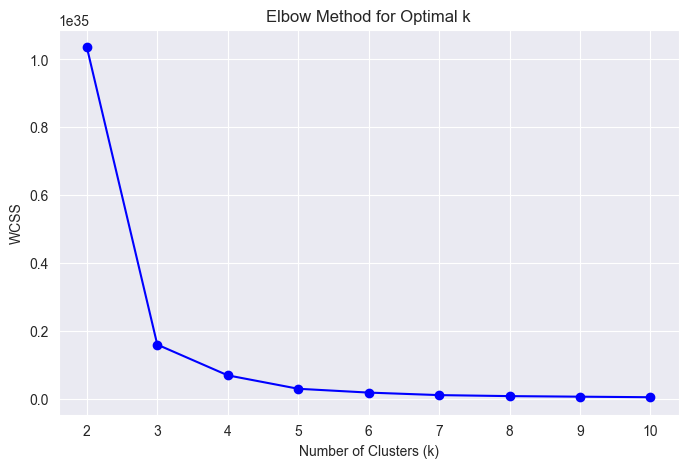

k=2: WCSS=103605773287448143647671106599387136.00
k=3: WCSS=15914925949575848926246805335703552.00
k=4: WCSS=6854095880530280203949206327525376.00
k=5: WCSS=2895817488352851703499783424442368.00
k=6: WCSS=1768207480426153735382810184646656.00
k=7: WCSS=1028291650190788719780881860919296.00
k=8: WCSS=729872149516489339223712492158976.00
k=9: WCSS=562522764952685843734261447786496.00
k=10: WCSS=402883814687553505661447647002624.00


In [13]:
cluster_analyzer = ClusterAnalyzer(df=data_loader.df)
cluster_analyzer.find_best_k_elbow(k_min=2, k_max=10)

From the graph we can see the “elbow” appears at k = 3, which suggests that 3 clusters is a reasonable choice for our customer segmentation. Choosing k > 3 gives smaller WCSS improvements, so additional clusters may not add meaningful separation.

So we can use k = 3 to fit KMeans and assign cluster labels to your users.

For clustering, we will use the KMeans algorithm from the `sklearn` library. We will fit the model with the optimal number of clusters (k=3) and assign cluster labels to each user based on their purchasing behavior.

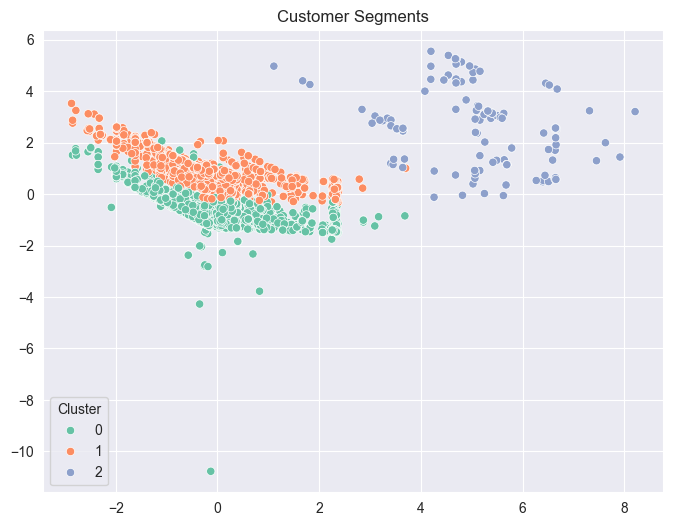

Cluster
0    3332
1    2686
2     154
Name: count, dtype: int64


In [14]:
cluster_model = KMeansClustering(data_loader.df, n_clusters=3)
cluster_model.preprocess()
df_clustered = cluster_model.fit()
cluster_model.visualize_clusters()
print(df_clustered['Cluster'].value_counts())



## 6.	Interpretation and Analysis
**Analyze the characteristics of each customer segment. What distinguishes one segment from another?**
* **Cluster 0 (3332 customers)** – largest group, mostly overlapping along the lower-left region. Likely represents average or low activity customers, maybe “Regular Shoppers.”
* **Cluster 1 (2686 customers)** – second largest, spread a bit above cluster 0. Could be moderately engaged customers, maybe “Occasional Spenders.”
* **Cluster 2 (154 customers)** – very small, clearly separated in the upper-right region. Likely high-value or premium customers, maybe “Premium Loyal” or “High Spenders.”

The clusters are distinguished by their purchasing behavior, with Cluster 2 representing the most valuable customers who spend significantly more than others. Clusters 0 and 1 represent less engaged customers with lower spending.


### How can this data be used for personalized marketing strategies?
* For cluster 0 (3332 customers) – they are average spenders, we can use general promotions, cross-sell opportunities, and popular product recommendations to encourage more purchases.
* For cluster 1 (2686 customers) – they are engaged or higher-value customers. We can use targeted marketing campaigns, personalized emails, and loyalty programs to retain them.
* Cluster 2 (154 customers) – they are premium/high-value customers. We can use exclusive offers, personalized recommendations, and VIP treatment to retain them and encourage repeat purchases.

Overall: With these classifications, we can use focus ad spend on high-value segments, personalize content, and create retention strategies to move average customers up.